# Cell Matching Across Days
Experimental sessions are conducted across multiple days on the same mouse. When imaging the brain location on the same plane with **2-Photon Imaging**, the image will not be perfectly identical. The frame may be in a slighlty different location on the brain or at a slighlty different depth. Additionally, cells can move relative to eachother over time. Due to this, computational methods are required to identify which cell *Regions of Interest* (ROIs) are the same as the previous session.

We use the Allen Institute's [**Nway Matching**](https://github.com/AllenInstitute/ophys_nway_matching) pipeline for this which is described in more detail below.

### Environment Setup

In [1]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi_utils import dandi_download_open
from PIL import Image
from time import sleep

### Downloading Ophys NWB Files
Here you can download several files for a subject that you can run nway matching on. The pipeline can take in any number of input *sessions*, however, the input ophys data should be from the same imaging plane of the same subject. To specify your own file to use, set `dandiset_id` to be the dandiset id of the files you're interested in. Also set `input_dandi_filepaths` to be a list of the filepaths on dandi of each file you're interested in providing to **Nway Matching**. When accessing an embargoed dataset, set `dandi_api_key` to be your DANDI API key.

In [3]:
dandiset_id = "000336"
dandi_filepath_1 = "sub-621602/sub-621602_ses-1193555033-acq-1193675753_ophys.nwb"
dandi_filepath_2 = "sub-621602/sub-621602_ses-1194555869-acq-1194754135_ophys.nwb"
download_loc = "."

# here, specify the list dandi filepaths of the files you want to run cell matching on
# the subject ids should be the same, but the session ids should be different
input_dandi_filepaths = [dandi_filepath_1, dandi_filepath_2]

dandi_api_key = os.environ["DANDI_API_KEY"]

In [4]:
nwbs = [dandi_download_open(dandiset_id, filepath, download_loc, dandi_api_key=dandi_api_key) for filepath in input_dandi_filepaths]

File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
Error 401 while sending GET request to https://api.dandiarchive.org/api/dandisets/0

PATH                                               SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-621602_ses-1194555869-acq-1194754135_ophys.nwb 159.1 MB 159.1 MB         100%    -     done                   
Summary:                                           159.1 MB 159.1 MB                       1 done                 
                                                            100.00%                                               
Downloaded file to ./sub-621602_ses-1194555869-acq-1194754135_ophys.nwb
Opening file


In [5]:
# these should be similar values, indicating that the images are from the same imaging plane
for nwb in nwbs:
    print(nwb.lab_meta_data["metadata"].imaging_depth)

309
309


### Generating Cell-Matching Input File
The Allen Institute has created a robust pipeline for conducting cell matching between 2 or more sessions called [**Nway Matching**](https://github.com/AllenInstitute/ophys_nway_matching). For those who are inquisitive, the general algorithm is described in page 31 of [{cite}`Garrett2023`](https://www.biorxiv.org/content/10.1101/2023.02.14.528085v2.full.pdf). In summary, the input images are aligned together with a euclidian image registration technique. Then the given input ROI masks are used with the [Blossom Algorithm](https://en.wikipedia.org/wiki/Blossom_algorithm) as a bipartite graph matching algorithm. This identifies which ROIs represent the same cells with high probability.

The caveat to using this pipeline is that it requires input in a specific JSON format rather than an NWB File. The following functions are used to generate a file, `input.json`, which can be used to obtain important output. The input json contains an entry for each input experiment. 2 or more experiments can be used. The first experiment is called *fixed* and the other ones are *moving*. For each experiment, a unique experiment ID, a path to the experiment projection image, and a list of objects for each ROI are required.

In [6]:
### for each ROI in an ROI table, create a JSON object containing its information, return a list of JSON objects

def make_roi_entries(roi_table):
    roi_entries = []
    for roi_idx in range(len(roi_table)):
        x = int(roi_table["x"][roi_idx])
        y = int(roi_table["y"][roi_idx])
        height = int(roi_table["height"][roi_idx])
        width = int(roi_table["width"][roi_idx])
        
        mask_subimage = roi_table["image_mask"][roi_idx][y:y+height,x:x+width]
        
        roi_entry = {
            "id": int(roi_table["id"][roi_idx]),
            "valid": bool(roi_table["valid_roi"][roi_idx]),
            "x": x,
            "y": y,
            "z": 1,
            "width": width,
            "height": height,
            # convert 2D array to 2D list of bools
            "mask_matrix": [[bool(elem) for elem in row] for row in mask_subimage]
        }
        roi_entries.append(roi_entry)
    return roi_entries

In [7]:
### take in an image array and return it converted to uint16

def normalize_to_16b(image_array):
    image_array = image_array * 2**8
    return image_array.astype(np.uint16)

In [8]:
### convert an nwb object into a 'experiment' JSON object with the required format

def nwb_to_experiment_json(nwb):
    # save image here
    grayscale_image = np.array(nwb.processing["ophys"]["images"]["average_image"])
    image_array = normalize_to_16b(np.array(grayscale_image))
    image_file = Image.fromarray(image_array)
    image_file = image_file.convert("L")
    image_file.save(f"./{nwb.identifier}_image.png")

    roi_table = nwb.processing["ophys"]["image_segmentation"]["cell_specimen_table"]
    
    experiment = {
        "id": nwb.identifier, 
        "ophys_average_intensity_projection_image": f"./{nwb.identifier}_image.png",
        "cell_rois": make_roi_entries(roi_table)
    }

    return experiment

In [9]:
### make the input json object, populate its experiments field with an experiment object for each nwb object

input_exps = {
    "experiment_containers": {
        "ophys_experiments": []
    }
}

for nwb in nwbs:
    experiment = nwb_to_experiment_json(nwb)
    input_exps["experiment_containers"]["ophys_experiments"].append(experiment)

with open("input.json", "w") as f:
    json.dump(input_exps, f, indent=2)

### Running the Algorithm
**Nway Matching** can be run as a command with the following parameters. From there, several output files are generated.

In [10]:
!python -m nway.nway_matching --input_json input.json --output_json "./output.json" --output_dir matching_output

INFO:NwayMatching:NWAY_COMMIT_SHA None
INFO:NwayMatching:Nway matching version 0.6.0
INFO:PairwiseMatching:Matching 1193675753 to 1194754135
INFO:PairwiseMatching:Matching 1193675753 to 1194754135: best registration was ['Identity']
C:\Users\carter.peene\AppData\Roaming\Python\Python39\site-packages\nway\utils.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.sort_index(0)
C:\Users\carter.peene\AppData\Roaming\Python\Python39\site-packages\nway\utils.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.sort_index(1)
INFO:NwayMatching:registration success(1) or failure (0):
   0  1
0  1  0
1  0  1
id map{
  "0": 1193675753,
  "1": 1194754135
}
Traceback (most recent call last):
  File "c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c

### Showing Cell Matching Output
The cell matching pipeline outputs the data as a output JSON, and a few plots as `.png` images. The paths to the plots are fetched from the output JSON and displayed below. Additionally, the output json contains a list of matching ROI IDs from each image.

In [11]:
with open("output.json", "r") as f:
    output = json.load(f)

(-0.5, 560.5, 2951.5, -0.5)

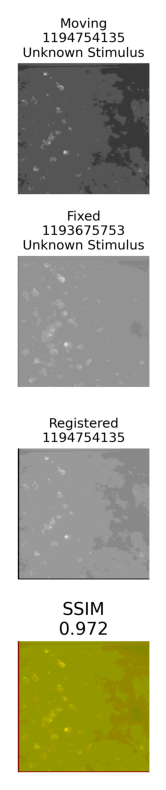

In [12]:
summary_plot = Image.open(output["nway_warp_summary_plot"])
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(summary_plot)
ax.axis("off")

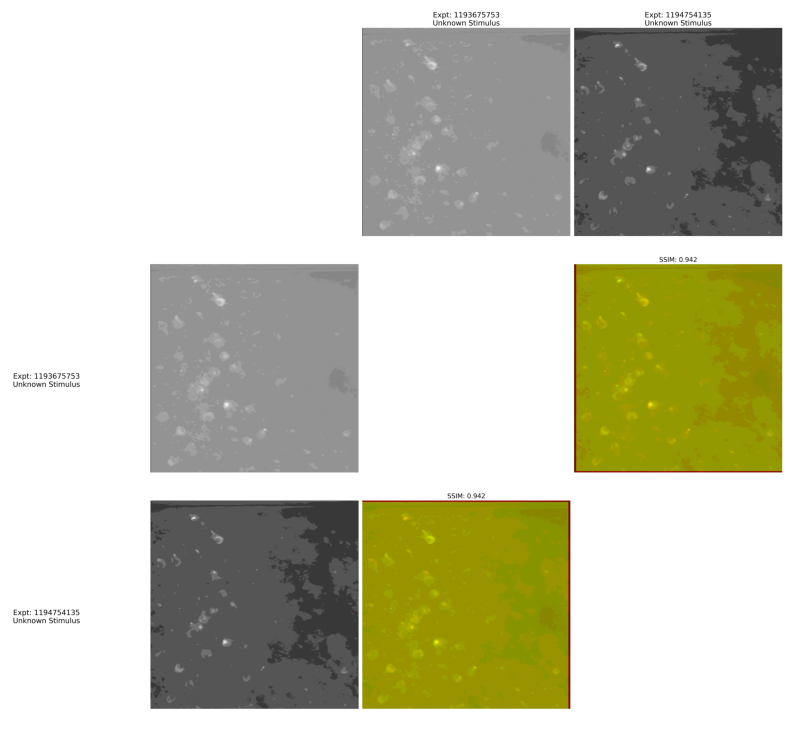

In [13]:
overlay_plot = Image.open(output["nway_warp_overlay_plot"])
fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(overlay_plot)

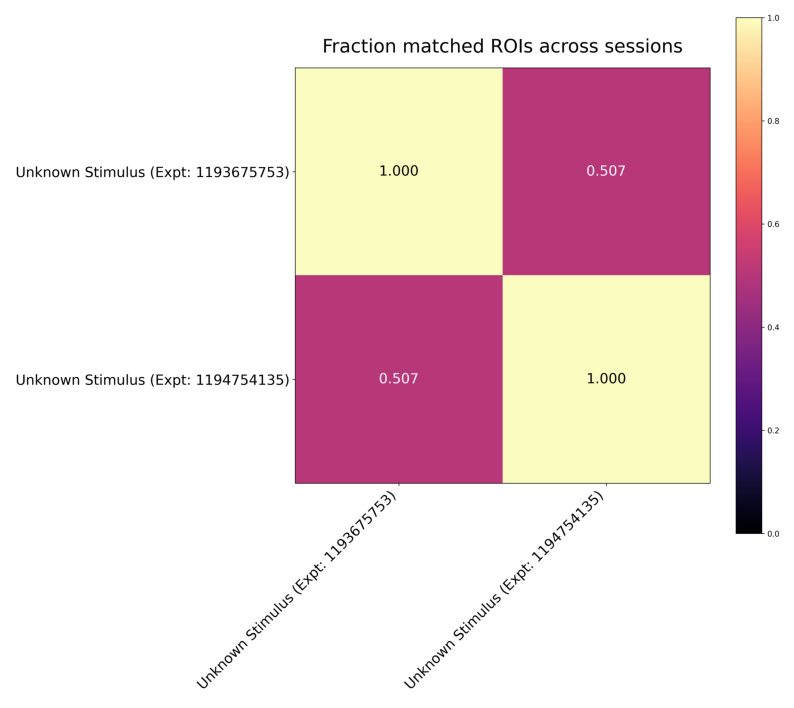

In [14]:
fraction_plot = Image.open(output["nway_match_fraction_plot"])
fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(fraction_plot)

### Visualizing Matching Cells
Apart from the image plots above, the main other part of the output is the `nway_matches` list, which contains a list of tuples the contain ROI IDs that *match* between session. The tuples are at most length n, where n is the number of experiments the **Nway Matching** pipeline was given, but some tuples will be shorter if a match wasn't found. The code below uses these tuples of matching IDs, along with the ROI masks in each NWB file's ROI tables, and generates n images that use color to show the matching ROIs between sessions.

In [15]:
# takes an ROI mask, colors it, adds it onto image
def add_color_mask(image, mask, color):
    black = [0,0,0]
    color_mask = np.array([[(color if boolean else black) for boolean in row] for row in mask])
    merged_image = np.where(color_mask!=black, color_mask, image)
    return merged_image

In [16]:
# generates a "random" color based on n
def gen_color(n):
    return [n*270 % 255, n*610 % 255, n*890 % 255]

In [17]:
# finds the table and image index that an ROI id belongs to
def get_image_num(id):
    for i in range(len(nwbs)):
        if id in roi_tables[i].index:
            return i

In [18]:
### for every match in the output, generate images which consist of ROI masks that supposedly match between sessions

# roi_tables correspond to images based on index of nwb in nwds list
roi_tables = [nwb.processing["ophys"]["image_segmentation"]["cell_specimen_table"].to_dataframe() for nwb in nwbs]
images = [np.zeros((512,512,3)).astype("uint8") for nwb in nwbs]
nway_matches = output["nway_matches"]

# for every list of matching IDs, generate a color, and add the ROI masks with those IDs to their respective images
for i in range(len(nway_matches)):
    match = nway_matches[i]
    # unmatched ROIs will be shown white
    if len(match) == 1:
        color = [255,255,255]
    else:
        color = gen_color(i)

    for id in match:
        # n is the index of which image and which ROI table this ROI belongs to
        n = get_image_num(id)        
        roi_table = roi_tables[n]
        # casting mask entry from roi table into np array
        mask = roi_table[roi_table.index==id].image_mask.to_numpy()[0]
        
        # add mask to image with given color
        images[n] = add_color_mask(images[n], mask, color)

Text(0.5, 0.98, 'Matched ROIs between sessions\n(White ROIs are unmatched)')

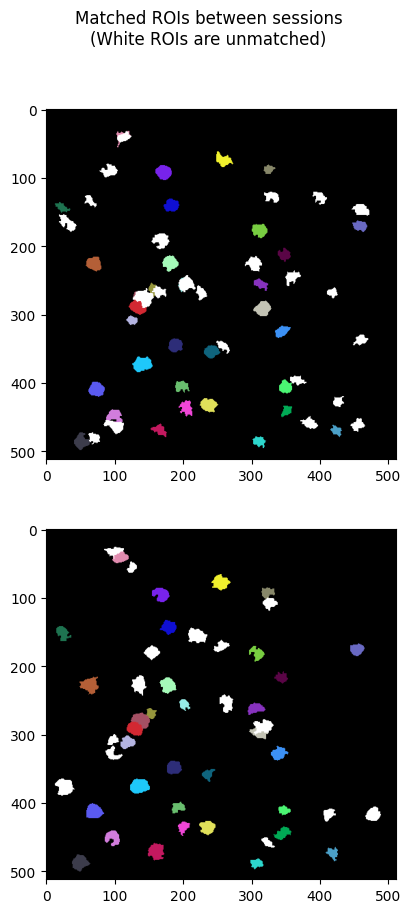

In [19]:
fig, axs = plt.subplots(len(images), figsize=(10,10))
for i in range(len(images)):
    axs[i].imshow(images[i])
fig.suptitle("Matched ROIs between sessions\n(White ROIs are unmatched)")